In [1]:
# percent_time_swimming.py
# Compute % time swimming per 1-second bin for each file (Trial_ID) and condition
# from a CSV of bout start/end frames.

import pandas as pd
import numpy as np
from typing import Optional, List, Dict

# --------------------------------------------------------------------------
# CONFIGURATION
# --------------------------------------------------------------------------
INPUT_PATH = r"C:\Maha\DATA\ventricle\240126\globalParametersInsideCategories.csv"
OUTPUT_PATH = r"C:\Maha\DATA\ventricle\240126\percent_time_swimming_per_file_140.csv"
SR = 100  # frames per second (adjust if needed)
BIN_SIZE_S = 1.0  # seconds per time bin
# --------------------------------------------------------------------------


# ---------- Helpers -------------------------------------------------------

def normalize(s: str) -> str:
    """Simplify string for fuzzy column name matching."""
    return "".join(ch.lower() for ch in s if ch.isalnum())


def find_best_match(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    """Find best matching column for a list of possible names."""
    norm_cols = {normalize(c): c for c in df.columns}
    # exact normalized match
    for cand in candidates:
        nc = normalize(cand)
        if nc in norm_cols:
            return norm_cols[nc]
    # substring match
    for cand in candidates:
        nc = normalize(cand)
        for col in df.columns:
            if nc in normalize(col):
                return col
    return None


def auto_map_columns(df: pd.DataFrame) -> Dict[str, Optional[str]]:
    """Try to identify BoutStart, BoutEnd, Trial_ID, and Condition columns."""
    start_candidates = ["BoutStart", "Bout Start", "StartFrame", "Start Frame", "Start"]
    end_candidates = ["BoutEnd", "Bout End", "EndFrame", "End Frame", "End"]
    trial_candidates = ["Trial_ID", "TrialID", "Trial", "File", "Recording", "Video", "Fish_ID"]
    condition_candidates = ["Condition", "Group", "Treatment", "Genotype", "Stimulus", "Stim", "Cond"]

    return {
        "BoutStart": find_best_match(df, start_candidates),
        "BoutEnd": find_best_match(df, end_candidates),
        "Trial_ID": find_best_match(df, trial_candidates),
        "Condition": find_best_match(df, condition_candidates),
    }


# ---------- Main ----------------------------------------------------------

def main(input_path=INPUT_PATH, output_path=OUTPUT_PATH, sr=SR, bin_size_s=BIN_SIZE_S):
    print(f"\nReading: {input_path}")
    df = pd.read_csv(input_path)

    # Identify columns
    column_map = auto_map_columns(df)
    if column_map["BoutStart"] is None or column_map["BoutEnd"] is None:
        preview = pd.DataFrame({
            "Expected": list(column_map.keys()),
            "Matched Column": [column_map[k] for k in column_map.keys()]
        })
        print("Could not locate required columns for bout start/end.\nDetected mapping:")
        print(preview.to_string(index=False))
        print("\nAvailable columns:", list(df.columns))
        raise ValueError("Missing BoutStart/BoutEnd columns. Adjust mapping logic or rename columns.")

    # Standardize column names
    wdf = df.rename(columns={
        column_map["BoutStart"]: "BoutStart",
        column_map["BoutEnd"]: "BoutEnd",
        **({column_map["Trial_ID"]: "Trial_ID"} if column_map["Trial_ID"] else {}),
        **({column_map["Condition"]: "Condition"} if column_map["Condition"] else {}),
    }).copy()

    # Fill defaults if optional columns are missing
    if "Trial_ID" not in wdf.columns:
        wdf["Trial_ID"] = "File_1"
    if "Condition" not in wdf.columns:
        wdf["Condition"] = "Condition_1"

    # Clean and convert to numeric
    wdf["BoutStart"] = pd.to_numeric(wdf["BoutStart"], errors="coerce")
    wdf["BoutEnd"] = pd.to_numeric(wdf["BoutEnd"], errors="coerce")
    wdf = wdf.dropna(subset=["BoutStart", "BoutEnd"])
    if wdf.empty:
        raise ValueError("No valid bout start/end values found after cleaning.")

    # Convert frames to seconds
    wdf["bout_start_time_sec"] = wdf["BoutStart"] / sr
    wdf["bout_end_time_sec"] = wdf["BoutEnd"] / sr

    # Prepare output
    records = []
    max_time = float(wdf["bout_end_time_sec"].max())
    time_edges = np.arange(0, max_time + bin_size_s, bin_size_s)

    print(f"Processing {wdf['Trial_ID'].nunique()} files × {wdf['Condition'].nunique()} conditions ...")

    # Compute per-bin swimming time
    for (file_id, condition), sub in wdf.groupby(["Trial_ID", "Condition"]):
        for i in range(len(time_edges) - 1):
            start_time, end_time = time_edges[i], time_edges[i + 1]

            # Select bouts overlapping this bin
            overlap_mask = (sub["bout_start_time_sec"] < end_time) & (sub["bout_end_time_sec"] > start_time)
            if not overlap_mask.any():
                swim_time = 0.0
            else:
                overlaps = np.minimum(sub.loc[overlap_mask, "bout_end_time_sec"], end_time) - \
                           np.maximum(sub.loc[overlap_mask, "bout_start_time_sec"], start_time)
                swim_time = float(np.clip(overlaps, 0, None).sum())

            percent_swimming = (swim_time / bin_size_s) * 100.0
            records.append({
                "file": file_id,
                "time_bin": start_time + bin_size_s / 2.0,
                "percent_time_swimming": percent_swimming,
                "condition": condition
            })

    result = pd.DataFrame.from_records(records)
    result.to_csv(output_path, index=False)
    print(f"\n✅ Saved: {output_path}")
    print(result.head(10))


# ---------- Entry ----------------------------------------------------------
if __name__ == "__main__":
    main()



Reading: C:\Maha\DATA\ventricle\240126\globalParametersInsideCategories.csv
Processing 14 files × 1 conditions ...

✅ Saved: C:\Maha\DATA\ventricle\240126\percent_time_swimming_per_file_140.csv
                            file  time_bin  percent_time_swimming condition
0  F10_t1_2026_01_18-19_46_20.h5       0.5                    0.0     opsin
1  F10_t1_2026_01_18-19_46_20.h5       1.5                    0.0     opsin
2  F10_t1_2026_01_18-19_46_20.h5       2.5                    0.0     opsin
3  F10_t1_2026_01_18-19_46_20.h5       3.5                   25.0     opsin
4  F10_t1_2026_01_18-19_46_20.h5       4.5                   65.0     opsin
5  F10_t1_2026_01_18-19_46_20.h5       5.5                    2.0     opsin
6  F10_t1_2026_01_18-19_46_20.h5       6.5                    0.0     opsin
7  F10_t1_2026_01_18-19_46_20.h5       7.5                    0.0     opsin
8  F10_t1_2026_01_18-19_46_20.h5       8.5                    0.0     opsin
9  F10_t1_2026_01_18-19_46_20.h5       9.5   


✅ Loaded CSV: C:\Maha\DATA\ventricle\240126\percent_time_swimming_140nM.csv
                            file  time_bin  percent_time_swimming condition
0  F10_t1_2026_01_18-19_46_20.h5       0.5                      0     opsin
1  F10_t1_2026_01_18-19_46_20.h5       1.5                      0     opsin
2  F10_t1_2026_01_18-19_46_20.h5       2.5                      0     opsin
3  F10_t1_2026_01_18-19_46_20.h5       3.5                     25     opsin
4  F10_t1_2026_01_18-19_46_20.h5       4.5                     65     opsin
5  F10_t1_2026_01_18-19_46_20.h5       5.5                      2     opsin
6  F10_t1_2026_01_18-19_46_20.h5       6.5                      0     opsin
7  F10_t1_2026_01_18-19_46_20.h5       7.5                      0     opsin
8  F10_t1_2026_01_18-19_46_20.h5       8.5                      0     opsin
9  F10_t1_2026_01_18-19_46_20.h5       9.5                      0     opsin


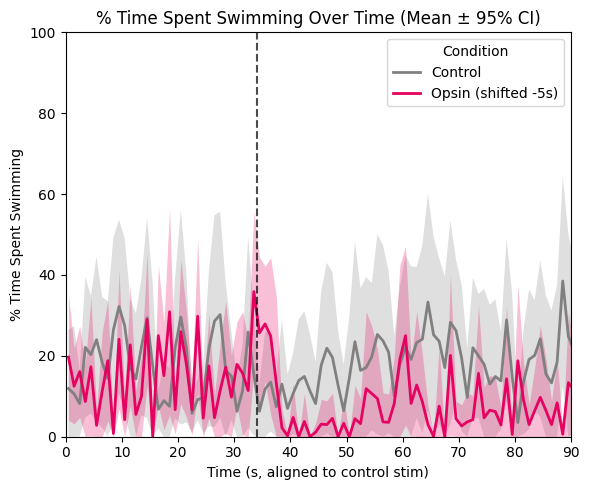


Saved plots:
- C:\Maha\DATA\ventricle\240126\plots\swimming_mean_ci.pdf
- C:\Maha\DATA\ventricle\240126\plots\swimming_mean_ci.svg

✅ Done.


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_from_csv(input_csv, OUT_PDF, OUT_SVG):
    # --------- LOAD CSV ---------
    result = pd.read_csv(input_csv)
    print(f"\n✅ Loaded CSV: {input_csv}")
    print(result.head(10))

    # --------- CLEAN / COERCE TYPES ---------
    missing = {"condition", "time_bin", "percent_time_swimming"} - set(result.columns)
    if missing:
        raise ValueError(
            f"CSV is missing required columns: {sorted(missing)}. "
            f"Found columns: {list(result.columns)}"
        )

    result["condition"] = result["condition"].astype(str).str.strip().str.lower()
    result["time_bin"] = pd.to_numeric(result["time_bin"], errors="coerce")
    result["percent_time_swimming"] = pd.to_numeric(result["percent_time_swimming"], errors="coerce")
    result = result.dropna(subset=["time_bin", "percent_time_swimming", "condition"]).copy()
    result["percent_time_swimming"] = result["percent_time_swimming"].clip(0, 100)

    
    SHIFT_S = 5 

    
    result.loc[result["condition"] == "opsin", "time_bin"] = (
        result.loc[result["condition"] == "opsin", "time_bin"] - SHIFT_S
    )

   
    result = result[result["time_bin"] >= 0].copy()
    # ------------------------------------------------------------

    # --------- GROUP STATS: mean ± 95% CI ---------
    grp = (
        result.groupby(["condition", "time_bin"])["percent_time_swimming"]
        .agg(mean="mean", std="std", count="count")
        .reset_index()
    )

    grp["std"] = grp["std"].fillna(0)
    grp["se"] = grp["std"] / np.sqrt(grp["count"].clip(lower=1))
    grp["ci_low"] = grp["mean"] - 1.96 * grp["se"]
    grp["ci_high"] = grp["mean"] + 1.96 * grp["se"]

    grp["ci_low"] = grp["ci_low"].clip(0, 100)
    grp["ci_high"] = grp["ci_high"].clip(0, 100)

    # --------- PLOT ---------
    COLOR_MAP = {
        "control": "grey",
        "opsin": "#e60260",
    }
    LABEL_MAP = {
        "control": "Control",
        "opsin": "Opsin (shifted -5s)",
    }

    plt.figure(figsize=(6, 5))

    plot_order = [c for c in ["control", "opsin"] if c in grp["condition"].unique()]
    plot_order += [c for c in grp["condition"].unique() if c not in plot_order]

    for cond in plot_order:
        sub = grp[grp["condition"] == cond].sort_values("time_bin")
        if sub.empty:
            continue

        color = COLOR_MAP.get(cond, "black")

        plt.plot(
            sub["time_bin"],
            sub["mean"],
            label=LABEL_MAP.get(cond, cond),
            color=color,
            linewidth=2,
        )
        plt.fill_between(
            sub["time_bin"],
            sub["ci_low"],
            sub["ci_high"],
            color=color,
            alpha=0.25,
            linewidth=0,
        )

    plt.xlabel("Time (s, aligned to control stim)")
    plt.ylabel("% Time Spent Swimming")
    plt.title("% Time Spent Swimming Over Time (Mean ± 95% CI)")
    plt.ylim(0, 100)
    plt.xlim(0, 90)

    # Vertical line at aligned stim time (34s)
    plt.axvline(x=CTRL_STIM_S, color="black", linestyle="--", linewidth=1.5, alpha=0.7)

    plt.legend(title="Condition")
    plt.tight_layout()

    # --------- SAVE ---------
    for path in [OUT_PDF, OUT_SVG]:
        out_dir = os.path.dirname(path)
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
        plt.savefig(path, bbox_inches="tight")

    plt.show()

    print(f"\nSaved plots:\n- {OUT_PDF}\n- {OUT_SVG}")
    print("\n✅ Done.")


def main():
    INPUT_CSV = r"C:\Maha\DATA\ventricle\240126\percent_time_swimming_140nM.csv"
    OUT_PDF = r"C:\Maha\DATA\ventricle\240126\plots\swimming_mean_ci.pdf"
    OUT_SVG = r"C:\Maha\DATA\ventricle\240126\plots\swimming_mean_ci.svg"

    plot_from_csv(INPUT_CSV, OUT_PDF, OUT_SVG)


if __name__ == "__main__":
    main()


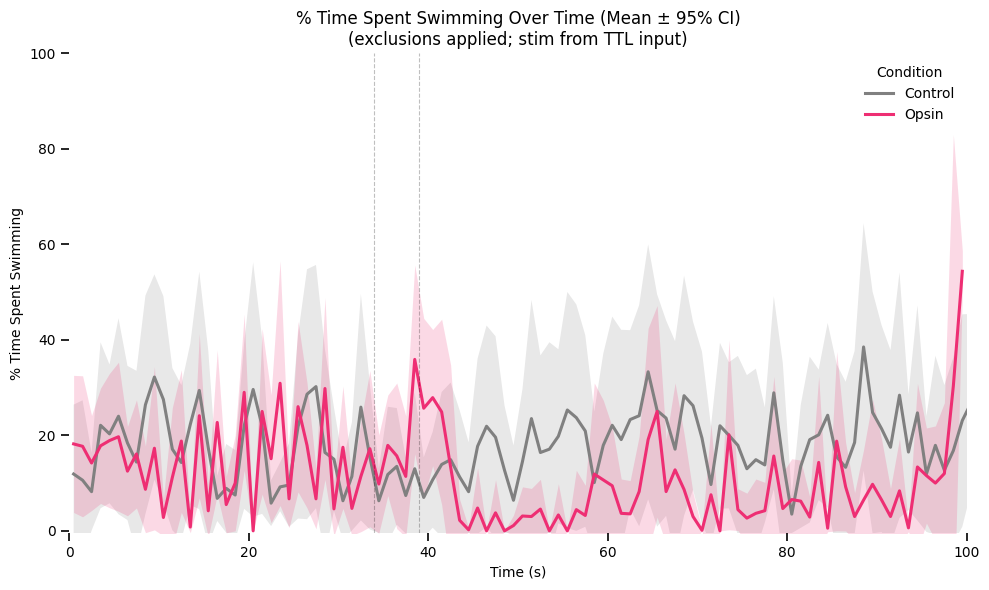


✅ Group stats (first few rows):
condition  time_bin  mean   std  count   se  ci_low  ci_high
  control      0.50 11.90 23.43     10 7.41   -2.62    26.42
  control      1.50 10.60 27.00     10 8.54   -6.13    27.33
  control      2.50  8.20 13.16     10 4.16    0.05    16.35
  control      3.50 22.10 28.03     10 8.86    4.73    39.47
  control      4.50 20.30 23.43     10 7.41    5.78    34.82

Saved plots:
- C:\Maha\DATA\ventricle\240126\percent_time_swimming_time_series_control_opsin_excluded_colored_vline.pdf
- C:\Maha\DATA\ventricle\240126\percent_time_swimming_time_series_control_opsin_excluded_colored_vline.svg

TTL file used:
- C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\stim_ttl_manual.csv


In [25]:
# Read-only version: NEVER prompts for input.
# - Uses stim_ttl_manual.csv if it exists; otherwise throws an error.
# - Derives stim onset per condition from TTL rising edge (0->1).
# - Plots mean ± 95% CI for control vs opsin and draws subtle stim lines.

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- CONFIG ----------------
DATA_CSV = Path(r"C:\Maha\DATA\ventricle\240126\percent_time_swimming_140nM.csv")

OUT_DIR = DATA_CSV.parent
OUT_PDF = OUT_DIR / "percent_time_swimming_time_series_control_opsin_excluded_colored_vline.pdf"
OUT_SVG = OUT_DIR / "percent_time_swimming_time_series_control_opsin_excluded_colored_vline.svg"

TTL_CSV = Path(r"C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\stim_ttl_manual.csv")

TARGET_CONDS = ["control", "opsin"]  # conditions to plot
TARGET_CONDS = [c.lower() for c in TARGET_CONDS]


EXCLUDE_FILES = {}

EXCLUDE_PREFIXES_ENABLE = False


# Colors
COLOR = {"control": "#808080", "opsin": "#ee2e73"}
LINEWIDTH = 2.2
ALPHA_BAND = 0.18

# Subtle stim line style
STIM_LINE_STYLE = {"color": "k", "linestyle": "--", "linewidth": 0.8, "alpha": 0.25}

# ---------------- HELPERS ----------------
def extract_prefix(fname: str) -> str:
    s = str(fname).strip()
    m = re.match(r"^([A-Za-z]+[0-9]+)", s)
    return m.group(1) if m else s.split("_")[0]

def stim_start_from_ttl(ttl_csv: Path, needed_conds):
    """
    Read TTL CSV and return dict {condition: stim_start_s} from first rising edge.
    Expects columns: condition, time_s, stim_ttl (0/1).
    """
    if not ttl_csv.exists():
        raise FileNotFoundError(
            f"TTL CSV not found:\n  {ttl_csv}\n"
            "Create it once (interactive) and re-run."
        )

    ttl = pd.read_csv(ttl_csv)

    for col in ["condition", "time_s", "stim_ttl"]:
        if col not in ttl.columns:
            raise ValueError(f"TTL CSV missing required column '{col}'. Found: {list(ttl.columns)}")

    ttl["condition"] = ttl["condition"].astype(str).str.strip().str.lower()
    ttl["time_s"] = pd.to_numeric(ttl["time_s"], errors="coerce")
    ttl["stim_ttl"] = pd.to_numeric(ttl["stim_ttl"], errors="coerce").fillna(0).astype(int)
    ttl = ttl.dropna(subset=["condition", "time_s"]).sort_values(["condition", "time_s"])

    starts = {}
    for cond in needed_conds:
        g = ttl[ttl["condition"] == cond].copy()
        if g.empty:
            raise ValueError(f"TTL CSV has no rows for condition '{cond}'.")
        rising = g.loc[g["stim_ttl"].diff().fillna(0) == 1, "time_s"]
        if rising.empty:
            raise ValueError(f"No TTL rising edge (0->1) found for condition '{cond}'.")
        starts[cond] = float(rising.iloc[0])

    return starts

# ---------------- TTL: read stim starts ----------------
STIM_START_BY_COND = stim_start_from_ttl(TTL_CSV, TARGET_CONDS)


# ---------------- LOAD DATA ----------------
df = pd.read_csv(DATA_CSV)

# Required columns check
need_cols = {"file", "condition", "time_bin", "percent_time_swimming"}
missing = need_cols - set(df.columns)
if missing:
    raise SystemExit(f"Data CSV missing columns: {sorted(missing)}")

# Basic cleaning
df["file"] = df["file"].astype(str).str.strip()
df["condition"] = df["condition"].astype(str).str.strip().str.lower()

# Keep only target conditions
df = df[df["condition"].isin(TARGET_CONDS)].copy()

# Exclude explicit files
lower_excl = {f.strip().lower() for f in EXCLUDE_FILES}
df = df[~df["file"].str.lower().isin(lower_excl)].copy()

# Optional: exclude prefixes
if EXCLUDE_PREFIXES_ENABLE:
    df["prefix"] = df["file"].map(extract_prefix)
    df = df[~df["prefix"].astype(str).str.upper().isin({p.upper() for p in EXCLUDE_PREFIXES})].copy()
    df = df.drop(columns=["prefix"])

# Ensure numeric
df["time_bin"] = pd.to_numeric(df["time_bin"], errors="coerce")
df["percent_time_swimming"] = pd.to_numeric(df["percent_time_swimming"], errors="coerce")
df = df.dropna(subset=["time_bin", "percent_time_swimming"]).copy()
df["percent_time_swimming"] = df["percent_time_swimming"].clip(0, 100)

if df.empty:
    raise SystemExit("No data left after filtering/exclusions.")

# ---------------- STATS PER TIME BIN ----------------
grp = (
    df.groupby(["condition", "time_bin"], as_index=False)["percent_time_swimming"]
      .agg(mean="mean", std="std", count="count")
)
grp["se"] = grp["std"] / np.sqrt(grp["count"].clip(lower=1))
grp["ci_low"] = grp["mean"] - 1.96 * grp["se"]
grp["ci_high"] = grp["mean"] + 1.96 * grp["se"]

# ---------------- PLOT ----------------
plt.figure(figsize=(10, 6))
ax = plt.gca()

for cond in TARGET_CONDS:
    sub = grp[grp["condition"] == cond].sort_values("time_bin")
    ax.plot(sub["time_bin"], sub["mean"],
            label=cond.capitalize(),
            color=COLOR.get(cond, "k"),
            linewidth=LINEWIDTH)
    ax.fill_between(sub["time_bin"], sub["ci_low"], sub["ci_high"],
                    color=COLOR.get(cond, "k"),
                    alpha=ALPHA_BAND, linewidth=0)

# Stim lines from TTL (subtle)
for cond in TARGET_CONDS:
    ax.axvline(STIM_START_BY_COND[cond], **STIM_LINE_STYLE)

ax.set_xlabel("Time (s)")
ax.set_ylabel("% Time Spent Swimming")
ax.set_ylim(-0.5, 100)
ax.set_title("% Time Spent Swimming Over Time (Mean ± 95% CI)\n(exclusions applied; stim from TTL input)")
ax.legend(title="Condition", frameon=False)

ax.set_facecolor("white")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.tick_params(direction="out", length=6, width=1.2)
plt.box(False)
plt.xlim(0,100)
plt.tight_layout()

# Save
os.makedirs(str(OUT_DIR), exist_ok=True)
plt.savefig(OUT_PDF, bbox_inches="tight")
plt.savefig(OUT_SVG, bbox_inches="tight")
plt.show()

print("\n✅ Group stats (first few rows):")
print(grp.head().to_string(index=False, float_format=lambda x: f"{x:.2f}"))
print(f"\nSaved plots:\n- {OUT_PDF}\n- {OUT_SVG}")
print(f"\nTTL file used:\n- {TTL_CSV}")


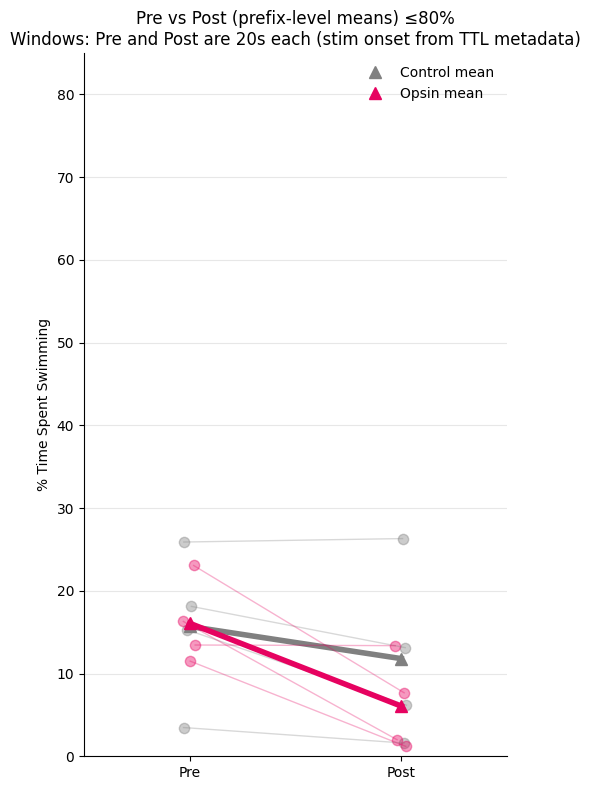

✅ Saved plots:
- C:\Maha\DATA\ventricle\240126\overlay_pre_post_prefix_means_nododge_withlines_1.pdf
- C:\Maha\DATA\ventricle\240126\overlay_pre_post_prefix_means_nododge_withlines_1.svg


In [24]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- CONFIG ----------------
INPUT = r"C:\Maha\DATA\ventricle\240126\percent_time_swimming_140nM.csv"
OUT_PDF = r"C:\Maha\DATA\ventricle\240126\overlay_pre_post_prefix_means_nododge_withlines_1.pdf"
OUT_SVG = r"C:\Maha\DATA\ventricle\240126\overlay_pre_post_prefix_means_nododge_withlines_1.svg"

TARGET_CONDS = ["control", "opsin"]
TARGET_CONDS = [c.lower() for c in TARGET_CONDS]

# Use SAME TTL CSV (read-only; will NOT prompt)
TTL_CSV = Path(r"C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\stim_ttl_manual.csv")

WIN = 20.0  # Pre=[STIM-WIN, STIM), Post=[STIM, STIM+WIN)

MAX_VALID_MEAN = 80.0   # set None to disable
EXCLUDE_FILES = {}      # e.g. {"badfile1.h5", ...}

COLOR_CTRL = "#808080"
COLOR_OPSIN = "#e60260"

STRIP_ALPHA = 0.4
STRIP_SIZE = 55
MEAN_LINE_WIDTH = 4.0
MEAN_MARKER_SIZE = 9
Y_LIM = (0, 85)
FIGSIZE = (5, 8)
JITTER = 0.03

# --------------------------------------

def extract_prefix(fname: str) -> str:
    s = str(fname).strip()
    m = re.match(r"^([A-Za-z]+[0-9]+)", s)
    return m.group(1) if m else s.split("_")[0]

def stim_start_from_ttl(ttl_csv: Path, needed_conds):
    """Return dict {condition: stim_start_s} from first TTL rising edge."""
    if not ttl_csv.exists():
        raise FileNotFoundError(f"TTL CSV not found: {ttl_csv}")

    ttl = pd.read_csv(ttl_csv)
    for col in ["condition", "time_s", "stim_ttl"]:
        if col not in ttl.columns:
            raise ValueError(f"TTL CSV missing '{col}'. Found: {list(ttl.columns)}")

    ttl["condition"] = ttl["condition"].astype(str).str.strip().str.lower()
    ttl["time_s"] = pd.to_numeric(ttl["time_s"], errors="coerce")
    ttl["stim_ttl"] = pd.to_numeric(ttl["stim_ttl"], errors="coerce").fillna(0).astype(int)
    ttl = ttl.dropna(subset=["condition", "time_s"]).sort_values(["condition", "time_s"])

    starts = {}
    for cond in needed_conds:
        g = ttl[ttl["condition"] == cond]
        if g.empty:
            raise ValueError(f"TTL CSV has no rows for condition '{cond}'.")
        rising = g.loc[g["stim_ttl"].diff().fillna(0) == 1, "time_s"]
        if rising.empty:
            raise ValueError(f"No TTL rising edge (0→1) for condition '{cond}'.")
        starts[cond] = float(rising.iloc[0])

    return starts

def main():
    # stim starts from TTL (no printing)
    STIM_START_BY_COND = stim_start_from_ttl(TTL_CSV, TARGET_CONDS)

    df = pd.read_csv(INPUT)
    required = {"file", "condition", "time_bin", "percent_time_swimming"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}. Found: {list(df.columns)}")

    # Clean
    df["file"] = df["file"].astype(str).str.strip()
    df["condition"] = df["condition"].astype(str).str.strip().str.lower()
    df["time_bin"] = pd.to_numeric(df["time_bin"], errors="coerce")
    df["percent_time_swimming"] = pd.to_numeric(df["percent_time_swimming"], errors="coerce")
    df = df.dropna(subset=["file", "condition", "time_bin", "percent_time_swimming"]).copy()
    df["percent_time_swimming"] = df["percent_time_swimming"].clip(0, 100)

    # Filter conditions
    df = df[df["condition"].isin(TARGET_CONDS)].copy()

    # Exclude files
    if EXCLUDE_FILES:
        excl = {f.lower() for f in EXCLUDE_FILES}
        df = df[~df["file"].str.lower().isin(excl)].copy()

    # Add stim start + window bounds per row
    df["stim_start_s"] = df["condition"].map(STIM_START_BY_COND)
    if df["stim_start_s"].isna().any():
        bad = sorted(df.loc[df["stim_start_s"].isna(), "condition"].unique().tolist())
        raise ValueError(f"Missing stim start for condition(s): {bad}. Check TTL CSV.")

    df["pre_a"] = df["stim_start_s"] - WIN
    df["pre_b"] = df["stim_start_s"]
    df["post_a"] = df["stim_start_s"]
    df["post_b"] = df["stim_start_s"] + WIN

    pre = df[(df["time_bin"] >= df["pre_a"]) & (df["time_bin"] < df["pre_b"])].copy()
    post = df[(df["time_bin"] >= df["post_a"]) & (df["time_bin"] < df["post_b"])].copy()

    # Per-file means
    pre_mean = (
        pre.groupby(["file", "condition"], as_index=False)["percent_time_swimming"]
           .mean()
           .rename(columns={"percent_time_swimming": "mean_pre"})
    )
    post_mean = (
        post.groupby(["file", "condition"], as_index=False)["percent_time_swimming"]
            .mean()
            .rename(columns={"percent_time_swimming": "mean_post"})
    )

    per_file = pd.merge(pre_mean, post_mean, on=["file", "condition"], how="inner")
    per_file["prefix"] = per_file["file"].map(extract_prefix)

    # Prefix-level means
    prefix_means = (
        per_file.groupby(["prefix", "condition"], as_index=False)
                .agg(
                    mean_pre=("mean_pre", "mean"),
                    mean_post=("mean_post", "mean"),
                    n_trials=("file", "nunique"),
                )
    )

    # Exclude by max valid mean
    if MAX_VALID_MEAN is not None:
        prefix_means = prefix_means[
            (prefix_means["mean_pre"] <= MAX_VALID_MEAN) &
            (prefix_means["mean_post"] <= MAX_VALID_MEAN)
        ].copy()

    # ---- Plot ----
    plt.figure(figsize=FIGSIZE)
    ax = plt.gca()

    X_PRE, X_POST = 0.0, 1.0
    rng = np.random.default_rng(0)

    def plot_points_and_mean(sub, color, label):
        j_pre = rng.uniform(-JITTER, JITTER, size=len(sub))
        j_post = rng.uniform(-JITTER, JITTER, size=len(sub))

        x_pre = np.full(len(sub), X_PRE) + j_pre
        x_post = np.full(len(sub), X_POST) + j_post

        y_pre = sub["mean_pre"].to_numpy(float)
        y_post = sub["mean_post"].to_numpy(float)

        ax.scatter(x_pre, y_pre, color=color, s=STRIP_SIZE, alpha=STRIP_ALPHA)
        ax.scatter(x_post, y_post, color=color, s=STRIP_SIZE, alpha=STRIP_ALPHA)

        for xp, xq, yp, yq in zip(x_pre, x_post, y_pre, y_post):
            ax.plot([xp, xq], [yp, yq], color=color, alpha=0.3, linewidth=1.0)

        if len(sub) > 0:
            mpre = float(np.mean(y_pre))
            mpost = float(np.mean(y_post))
            ax.plot([X_PRE, X_POST], [mpre, mpost], color=color, linewidth=MEAN_LINE_WIDTH)
            ax.plot([X_PRE, X_POST], [mpre, mpost], linestyle="None", marker="^",
                    color=color, markersize=MEAN_MARKER_SIZE, label=f"{label} mean")

    ctrl = prefix_means[prefix_means["condition"] == "control"].sort_values("prefix")
    ops = prefix_means[prefix_means["condition"] == "opsin"].sort_values("prefix")

    plot_points_and_mean(ctrl, COLOR_CTRL, "Control")
    plot_points_and_mean(ops, COLOR_OPSIN, "Opsin")

    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(*Y_LIM)
    ax.set_xticks([0, 1], ["Pre", "Post"])
    ax.set_ylabel("% Time Spent Swimming")
    ax.grid(True, axis="y", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Title WITHOUT stim times
    title = "Pre vs Post (prefix-level means)"
    if MAX_VALID_MEAN is not None:
        title += f" ≤{MAX_VALID_MEAN:.0f}%"
    title += f"\nWindows: Pre and Post are {WIN:.0f}s each (stim onset from TTL metadata)"
    ax.set_title(title)

    ax.legend(frameon=False, loc="best")
    plt.tight_layout()

    for path in [OUT_PDF, OUT_SVG]:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path, bbox_inches="tight")

    plt.show()

    print("✅ Saved plots:")
    print(f"- {OUT_PDF}")
    print(f"- {OUT_SVG}")

if __name__ == "__main__":
    main()


In [21]:
# paired_ttest_prefix_pre_post.py
# Paired t-test at the PREFIX (animal) level
# One-sided (H1: post < pre) for BOTH control and opsin
# Stim starts are READ from a TTL CSV (no hard-coded mapping)
# NOTE: does NOT print stim start times

import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
import re
from pathlib import Path

# ---------------- CONFIG ----------------
INPUT = r"C:\Maha\DATA\ventricle\240126\percent_time_swimming_140nM.csv"

TARGET_CONDS = ["control", "opsin"]
TARGET_CONDS = [c.lower() for c in TARGET_CONDS]

# SAME TTL CSV (read-only)
TTL_CSV = Path(r"C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\stim_ttl_manual.csv")

WIN = 20.0  # Pre=[STIM-WIN, STIM), Post=[STIM, STIM+WIN)

MAX_VALID_MEAN = 80.0  # set None to disable
EXCLUDE_FILES = set()
# --------------------------------------

def extract_prefix(fname):
    s = str(fname).strip()
    m = re.match(r"^([A-Za-z]+[0-9]+)", s)
    return m.group(1) if m else s.split("_")[0]

def stim_start_from_ttl(ttl_csv: Path, needed_conds):
    """
    Read TTL CSV and return dict {condition: stim_start_s} from first rising edge.
    Expects columns: condition, time_s, stim_ttl (0/1).
    """
    if not ttl_csv.exists():
        raise FileNotFoundError(f"TTL CSV not found: {ttl_csv}")

    ttl = pd.read_csv(ttl_csv)
    for col in ["condition", "time_s", "stim_ttl"]:
        if col not in ttl.columns:
            raise ValueError(f"TTL CSV missing required column '{col}'. Found: {list(ttl.columns)}")

    ttl["condition"] = ttl["condition"].astype(str).str.strip().str.lower()
    ttl["time_s"] = pd.to_numeric(ttl["time_s"], errors="coerce")
    ttl["stim_ttl"] = pd.to_numeric(ttl["stim_ttl"], errors="coerce").fillna(0).astype(int)
    ttl = ttl.dropna(subset=["condition", "time_s"]).sort_values(["condition", "time_s"])

    starts = {}
    for cond in needed_conds:
        g = ttl[ttl["condition"] == cond].copy()
        if g.empty:
            raise ValueError(f"TTL CSV has no rows for condition '{cond}'.")
        rising = g.loc[g["stim_ttl"].diff().fillna(0) == 1, "time_s"]
        if rising.empty:
            raise ValueError(f"No TTL rising edge (0→1) found for condition '{cond}'.")
        starts[cond] = float(rising.iloc[0])

    return starts

# ---- stim starts from TTL (no printing) ----
STIM_START_BY_COND = stim_start_from_ttl(TTL_CSV, TARGET_CONDS)

# -------- LOAD & CLEAN --------
df = pd.read_csv(INPUT)

df["file"] = df["file"].astype(str).str.strip()
df["condition"] = df["condition"].astype(str).str.strip().str.lower()
df["time_bin"] = pd.to_numeric(df["time_bin"], errors="coerce")
df["percent_time_swimming"] = pd.to_numeric(df["percent_time_swimming"], errors="coerce")

df = df.dropna(subset=["file", "condition", "time_bin", "percent_time_swimming"]).copy()
df["percent_time_swimming"] = df["percent_time_swimming"].clip(0, 100)
df = df[df["condition"].isin(TARGET_CONDS)].copy()

if EXCLUDE_FILES:
    excl = {f.lower() for f in EXCLUDE_FILES}
    df = df[~df["file"].str.lower().isin(excl)].copy()

df["prefix"] = df["file"].map(extract_prefix)

# -------- CONDITION-SPECIFIC WINDOW FILTER --------
df["stim_start_s"] = df["condition"].map(STIM_START_BY_COND)
missing = df["stim_start_s"].isna()
if missing.any():
    bad = sorted(df.loc[missing, "condition"].unique().tolist())
    raise ValueError(f"Missing stim start for condition(s): {bad}. Check TTL CSV.")

df["pre_a"] = df["stim_start_s"] - WIN
df["pre_b"] = df["stim_start_s"]
df["post_a"] = df["stim_start_s"]
df["post_b"] = df["stim_start_s"] + WIN

in_pre = (df["time_bin"] >= df["pre_a"]) & (df["time_bin"] < df["pre_b"])
in_post = (df["time_bin"] >= df["post_a"]) & (df["time_bin"] < df["post_b"])

df = df[in_pre | in_post].copy()
df["time"] = np.where(in_pre.loc[df.index], "pre", "post")

# -------- PREFIX-LEVEL MEANS --------
pm = (
    df.groupby(["prefix", "condition", "time"], observed=True)["percent_time_swimming"]
      .mean()
      .unstack("time")
      .reset_index()
).dropna(subset=["pre", "post"])

if MAX_VALID_MEAN is not None:
    pm = pm[(pm["pre"] <= MAX_VALID_MEAN) & (pm["post"] <= MAX_VALID_MEAN)].copy()

print("\n===== Paired t-tests (prefix-level; one-sided H1: post < pre) =====")
print(f"WIN = {WIN:.1f}s")

for cond in TARGET_CONDS:
    sub = pm[pm["condition"] == cond].copy()

    pre = sub["pre"].to_numpy(float)
    post = sub["post"].to_numpy(float)
    diff = post - pre

    n = len(pre)
    if n < 3:
        print(f"\n{cond.upper()}: too few prefixes (n={n})")
        continue

    # ---- stats ----
    t_stat, p_two = ttest_rel(pre, post)
    p_one = p_two / 2 if diff.mean() < 0 else 1 - p_two / 2

    # ---- mean ± SEM ----
    def mean_sem(x):
        x = np.asarray(x, dtype=float)
        return x.mean(), x.std(ddof=1) / np.sqrt(len(x))

    pre_m, pre_sem = mean_sem(pre)
    post_m, post_sem = mean_sem(post)
    diff_m, diff_sem = mean_sem(diff)

    print(f"\n{cond.upper()} (H1: post < pre)")
    print(f"n prefixes = {n}")
    print(f"PRE        = {pre_m:.2f} ± {pre_sem:.2f}")
    print(f"POST       = {post_m:.2f} ± {post_sem:.2f}")
    print(f"Δ(post−pre)= {diff_m:.2f} ± {diff_sem:.2f}")
    print(f"t = {t_stat:.3f}")
    print(f"two-sided p = {p_two:.4g}")
    print(f"one-sided p = {p_one:.4g}")



===== Paired t-tests (prefix-level; one-sided H1: post < pre) =====
WIN = 20.0s

CONTROL (H1: post < pre)
n prefixes = 4
PRE        = 15.70 ± 4.65
POST       = 11.81 ± 5.39
Δ(post−pre)= -3.89 ± 2.07
t = 1.884
two-sided p = 0.1561
one-sided p = 0.07805

OPSIN (H1: post < pre)
n prefixes = 4
PRE        = 14.91 ± 2.75
POST       = 6.06 ± 2.83
Δ(post−pre)= -8.84 ± 3.19
t = 2.769
two-sided p = 0.06963
one-sided p = 0.03481


#3mM


CONTROL: Paired t-test, p=0.2363 (n=4) Δmean=-1.89

OPSIN: Paired t-test, p=0.0329 (n=4) Δmean=-8.13


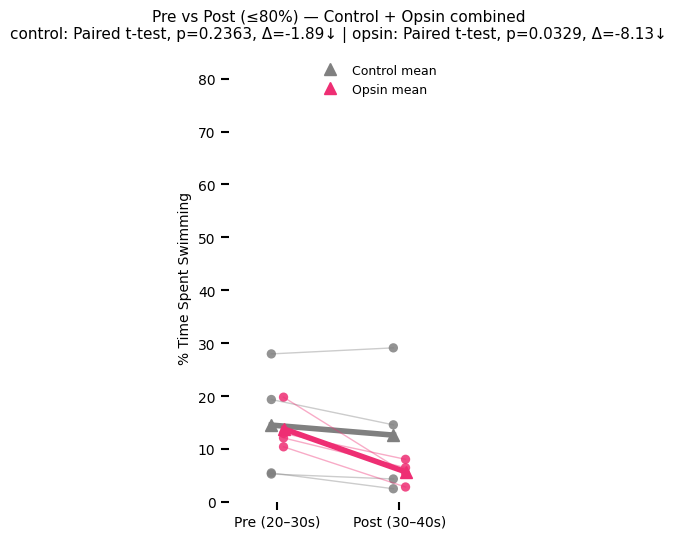


📊 Summary by condition (prefix-level means, ≤80%, excl. C1/C5/C6):
          mean_pre              mean_post             
              mean    std count      mean    std count
condition                                             
control      14.51  11.14     4     12.61  12.22     4
opsin        13.80   4.13     4      5.67   2.20     4

Saved plots:
- C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\pubready_pre_post_singleplot_exclude80_C1C5C6.pdf
- C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\pubready_pre_post_singleplot_exclude80_C1C5C6.svg


In [5]:
# paired_pre_post_singleplot_pubready_exclude80_C1C5C6.py
# Publication-ready Pre vs Post plot (Control + Opsin in one axis)
# Excludes >80% swimming, C1/C5/C6, and specified files.
# Clean style: no jitter, no background grid, no text labels.

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_rel, wilcoxon

# ---------------- CONFIG ----------------
INPUT = r"C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\percent_time_swimming_3mM.csv"
OUT_PDF = r"C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\pubready_pre_post_singleplot_exclude80_C1C5C6.pdf"
OUT_SVG = r"C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\pubready_pre_post_singleplot_exclude80_C1C5C6.svg"

TARGET_CONDS = ["control", "opsin"]
STIM_START_S = 30.0
WIN = 30.0
MAX_VALID = 80.0 
EXCLUDE_FILES = {
    
}
EXCLUDE_PREFIXES = {}

# Colors
COLOR_CTRL = "#808080"
COLOR_OPSIN = "#ee2e73"

# Style parameters
LINE_ALPHA = 0.4
PAIR_LINE_WIDTH = 1.0
MEAN_LINE_WIDTH = 4.0
MEAN_MARKER_SIZE = 9
STRIP_ALPHA = 0.85
STRIP_SIZE = 45
# ----------------------------------------

def extract_prefix(fname: str) -> str:
    """Extract prefix like 'C1', 'F9' from filename."""
    s = str(fname)
    m = re.match(r"^([A-Za-z]+[0-9]+)", s)
    return m.group(1) if m else s.split("_")[0]

def paired_stats(pre_vals, post_vals):
    """Return test name, p-value, and mean/median diff."""
    pre_vals, post_vals = np.array(pre_vals, float), np.array(post_vals, float)
    mask = ~np.isnan(pre_vals) & ~np.isnan(post_vals)
    pre_vals, post_vals = pre_vals[mask], post_vals[mask]
    n = len(pre_vals)
    if n < 3:
        return "Too few pairs", np.nan, n, np.nan, np.nan
    diff = post_vals - pre_vals
    mean_diff, median_diff = np.mean(diff), np.median(diff)
    normal = shapiro(diff).pvalue > 0.05 if n <= 5000 else True
    if normal:
        _, p = ttest_rel(pre_vals, post_vals)
        test_used = "Paired t-test"
    else:
        _, p = wilcoxon(pre_vals, post_vals)
        test_used = "Wilcoxon signed-rank"
    return test_used, float(p), n, mean_diff, median_diff

# -------- LOAD & CLEAN --------
df = pd.read_csv(INPUT)
df["condition"] = df["condition"].astype(str).str.strip().str.lower()
df = df[df["condition"].isin(TARGET_CONDS)].copy()

df["file"] = df["file"].astype(str).str.strip()
df["time_bin"] = pd.to_numeric(df["time_bin"], errors="coerce")
df["percent_time_swimming"] = pd.to_numeric(df["percent_time_swimming"], errors="coerce")
df = df.dropna(subset=["time_bin", "percent_time_swimming"])
df["percent_time_swimming"] = df["percent_time_swimming"].clip(0, 100)

# Exclude unwanted files and prefixes
df = df[~df["file"].str.lower().isin({f.lower() for f in EXCLUDE_FILES})].copy()

# -------- COMPUTE PRE/POST MEANS --------
pre_a, pre_b = STIM_START_S - WIN, STIM_START_S
post_a, post_b = STIM_START_S, STIM_START_S + WIN

pre = df[(df["time_bin"] >= pre_a) & (df["time_bin"] < pre_b)]
post = df[(df["time_bin"] >= post_a) & (df["time_bin"] < post_b)]

pre_mean = pre.groupby(["file", "condition"], as_index=False)["percent_time_swimming"].mean().rename(columns={"percent_time_swimming": "mean_pre"})
post_mean = post.groupby(["file", "condition"], as_index=False)["percent_time_swimming"].mean().rename(columns={"percent_time_swimming": "mean_post"})

per_file = pd.merge(pre_mean, post_mean, on=["file", "condition"], how="inner")
per_file["prefix"] = per_file["file"].map(extract_prefix)
per_file = per_file[~per_file["prefix"].str.upper().isin(EXCLUDE_PREFIXES)].copy()

# Collapse to prefix-level mean
prefix_means = (
    per_file.groupby(["prefix", "condition"], as_index=False)
            .agg(mean_pre=("mean_pre", "mean"),
                 mean_post=("mean_post", "mean"))
)

# Exclude outliers >80%
prefix_means = prefix_means[(prefix_means["mean_pre"] <= MAX_VALID) & (prefix_means["mean_post"] <= MAX_VALID)]

# -------- STATS --------
results = []
for cond in TARGET_CONDS:
    sub = prefix_means[prefix_means["condition"] == cond]
    test_used, pval, n, mean_diff, median_diff = paired_stats(sub["mean_pre"], sub["mean_post"])
    results.append((cond, test_used, pval, n, mean_diff, median_diff))
    print(f"\n{cond.upper()}: {test_used}, p={pval:.4f} (n={n}) Δmean={mean_diff:.2f}")

# -------- PLOT --------
plt.figure(figsize=(3, 5.5))
ax = plt.gca()

def plot_condition(sub, color, label, x_offset):
    # paired lines
    for _, r in sub.iterrows():
        ax.plot([0 + x_offset, 1 + x_offset],
                [r["mean_pre"], r["mean_post"]],
                color=color, alpha=LINE_ALPHA, linewidth=PAIR_LINE_WIDTH)
    # aligned strip dots (no jitter)
    ax.scatter(np.zeros(len(sub)) + x_offset, sub["mean_pre"],
               s=STRIP_SIZE, color=color, alpha=STRIP_ALPHA, edgecolors="none")
    ax.scatter(np.ones(len(sub)) + x_offset, sub["mean_post"],
               s=STRIP_SIZE, color=color, alpha=STRIP_ALPHA, edgecolors="none")
    # mean line + triangles
    if len(sub) > 0:
        mpre, mpost = sub["mean_pre"].mean(), sub["mean_post"].mean()
        ax.plot([0 + x_offset, 1 + x_offset], [mpre, mpost],
                color=color, linewidth=MEAN_LINE_WIDTH)
        ax.plot([0 + x_offset, 1 + x_offset],
                [mpre, mpost], linestyle="None", marker="^", color=color,
                markersize=MEAN_MARKER_SIZE, label=f"{label} mean")

# Plot both in same axis
plot_condition(prefix_means[prefix_means["condition"] == "control"], COLOR_CTRL, "Control", -0.05)
plot_condition(prefix_means[prefix_means["condition"] == "opsin"], COLOR_OPSIN, "Opsin", +0.05)

# Formatting
ax.set_xlim(-0.4, 1.4)
ax.set_ylim(0, 85)
ax.set_xticks([0, 1], ["Pre (20–30s)", "Post (30–40s)"])
ax.set_ylabel("% Time Spent Swimming")

# Remove background grid and spines for a clean look
ax.set_facecolor("white")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.tick_params(direction="out", length=6, width=1.5)
plt.box(False)

# Title with stats
title_bits = []
for cond, test_used, pval, n, mean_diff, _ in results:
    arrow = "↓" if mean_diff < 0 else "↑"
    title_bits.append(f"{cond}: {test_used}, p={pval:.4f}, Δ={mean_diff:.2f}{arrow}")
ax.set_title("Pre vs Post (≤80%) — Control + Opsin combined\n" + " | ".join(title_bits),
             fontsize=11, pad=10)

ax.legend(frameon=False, loc="best", fontsize=9)
plt.tight_layout()

# Save
for path in [OUT_PDF, OUT_SVG]:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, bbox_inches="tight")

plt.show()

# -------- SUMMARY --------
print("\n📊 Summary by condition (prefix-level means, ≤80%, excl. C1/C5/C6):")
summary = prefix_means.groupby("condition")[["mean_pre", "mean_post"]].agg(["mean", "std", "count"])
print(summary.round(2))
print(f"\nSaved plots:\n- {OUT_PDF}\n- {OUT_SVG}")


Excluded 0 file(s): []


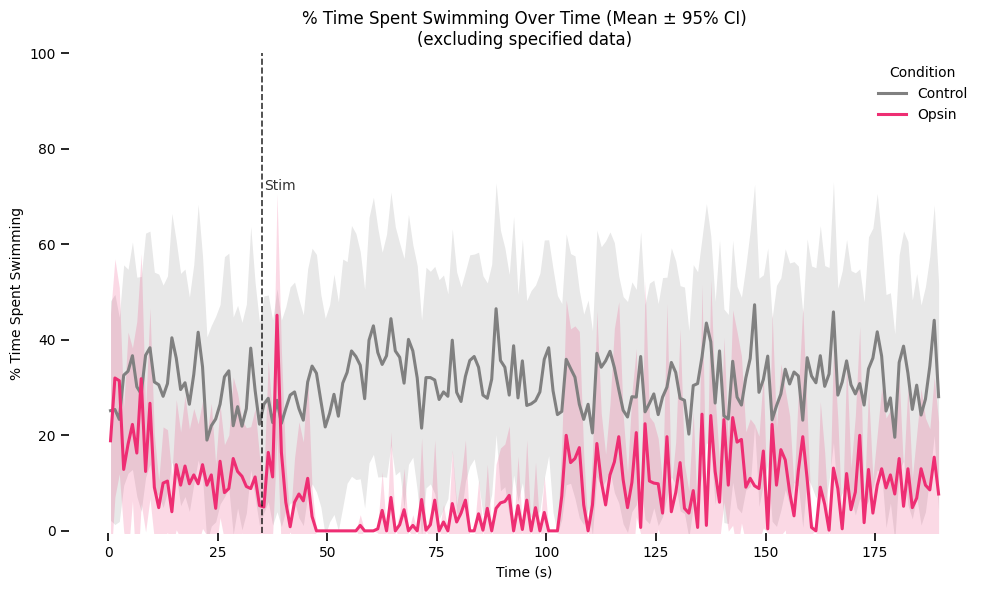


✅ Group stats (first few rows):
condition  time_bin  mean   std  count    se  ci_low  ci_high
  control      0.50 25.17 40.60     12 11.72    2.20    48.14
  control      1.50 25.42 42.57     12 12.29    1.33    49.50
  control      2.50 23.33 37.77     12 10.90    1.96    44.70
  control      3.50 32.58 40.80     12 11.78    9.50    55.67
  control      4.50 33.42 37.73     12 10.89   12.07    54.76

Saved plots:
- C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\percent_time_swimming_time_series_control_opsin_excluded_colored_vline.pdf
- C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\percent_time_swimming_time_series_control_opsin_excluded_colored_vline.svg


In [6]:
# percent_time_swimming_plot_control_opsin_exclude_colored_vline.py
# Mean ± 95% CI time series for control (grey) vs opsin (pink),
# excluding specified files (and optionally prefixes),
# with a vertical dashed line at stimulus onset (30 s).

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
INPUT   = r"C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\percent_time_swimming_3mM.csv"
OUT_PDF = r"C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\percent_time_swimming_time_series_control_opsin_excluded_colored_vline.pdf"
OUT_SVG = r"C:\Maha\DATA\ventricle\ZZoutput\allBoutsMixed\percent_time_swimming_time_series_control_opsin_excluded_colored_vline.svg"

TARGET_CONDS = ["control", "opsin"]
STIM_TIME_S = 35 # Stimulus onset time (s)

# Files to exclude (case-insensitive)
EXCLUDE_FILES = {}

# (Optional) exclude prefixes like C1/C5/C6
EXCLUDE_PREFIXES_ENABLE = False
EXCLUDE_PREFIXES = {}

# Colors
COLOR = {"control": "#808080", "opsin": "#ee2e73"}

LINEWIDTH = 2.2
ALPHA_BAND = 0.18
STIM_LINE_STYLE = {"color": "k", "linestyle": "--", "linewidth": 1.2, "alpha": 0.8}

# ---------------- HELPERS ----------------
def extract_prefix(fname: str) -> str:
    s = str(fname)
    m = re.match(r"^([A-Za-z]+[0-9]+)", s)
    return m.group(1) if m else s.split("_")[0]

# ---------------- LOAD ----------------
df = pd.read_csv(INPUT)

# Exclude files
df["file"] = df["file"].astype(str).str.strip()
lower_excl = {f.lower() for f in EXCLUDE_FILES}
mask_excl = df["file"].str.lower().isin(lower_excl)
removed = df.loc[mask_excl, "file"].unique().tolist()
df = df[~mask_excl].copy()
print(f"Excluded {len(removed)} file(s): {removed}")

# Normalize condition & keep only the two of interest
df["condition"] = df["condition"].astype(str).str.strip().str.lower()
df = df[df["condition"].isin(TARGET_CONDS)].copy()

# Optional: exclude prefixes C1/C5/C6
if EXCLUDE_PREFIXES_ENABLE:
    df["prefix"] = df["file"].map(extract_prefix)
    df = df[~df["prefix"].str.upper().isin({p.upper() for p in EXCLUDE_PREFIXES})].copy()
    print(f"Applied prefix exclusion: {sorted(EXCLUDE_PREFIXES)}")

# Ensure numeric
df["time_bin"] = pd.to_numeric(df["time_bin"], errors="coerce")
df["percent_time_swimming"] = pd.to_numeric(df["percent_time_swimming"], errors="coerce")
df = df.dropna(subset=["time_bin", "percent_time_swimming"])
df["percent_time_swimming"] = df["percent_time_swimming"].clip(0, 100)

# --- Compute mean ±95% CI per (time_bin, condition) ---
grp = (
    df.groupby(["condition", "time_bin"], as_index=False)["percent_time_swimming"]
      .agg(mean="mean", std="std", count="count")
)
grp["se"] = grp["std"] / np.sqrt(grp["count"].clip(lower=1))
grp["ci_low"] = grp["mean"] - 1.96 * grp["se"]
grp["ci_high"] = grp["mean"] + 1.96 * grp["se"]

# --- Plot (publication-ready) ---
plt.figure(figsize=(10, 6))
ax = plt.gca()

for cond in TARGET_CONDS:
    sub = grp[grp["condition"] == cond].sort_values("time_bin")
    ax.plot(sub["time_bin"], sub["mean"],
            label=cond.capitalize(),
            color=COLOR[cond], linewidth=LINEWIDTH)
    ax.fill_between(sub["time_bin"], sub["ci_low"], sub["ci_high"],
                    color=COLOR[cond], alpha=ALPHA_BAND, linewidth=0)

# --- Vertical line at 30 s (stim onset) ---
ax.axvline(STIM_TIME_S, **STIM_LINE_STYLE)
ax.text(STIM_TIME_S + 0.5, ax.get_ylim()[1]*0.95, "Stim", color="k",
        fontsize=10, va="top", ha="left", alpha=0.8)

# --- Axis and labels ---
ax.set_xlabel("Time (s)")
ax.set_ylabel("% Time Spent Swimming")
ax.set_ylim(-0.5, 100)
ax.set_title("% Time Spent Swimming Over Time (Mean ± 95% CI)\n(excluding specified data)")

# Clean, minimalist style
ax.legend(title="Condition", frameon=False)
ax.set_facecolor("white")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.tick_params(direction="out", length=6, width=1.2)
plt.box(False)
plt.tight_layout()

# --- Save ---
for path in [OUT_PDF, OUT_SVG]:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, bbox_inches="tight")

plt.show()

# --- Quick summary ---
print("\n✅ Group stats (first few rows):")
print(grp.head().to_string(index=False, float_format=lambda x: f"{x:.2f}"))
print(f"\nSaved plots:\n- {OUT_PDF}\n- {OUT_SVG}")


plotting tail angle

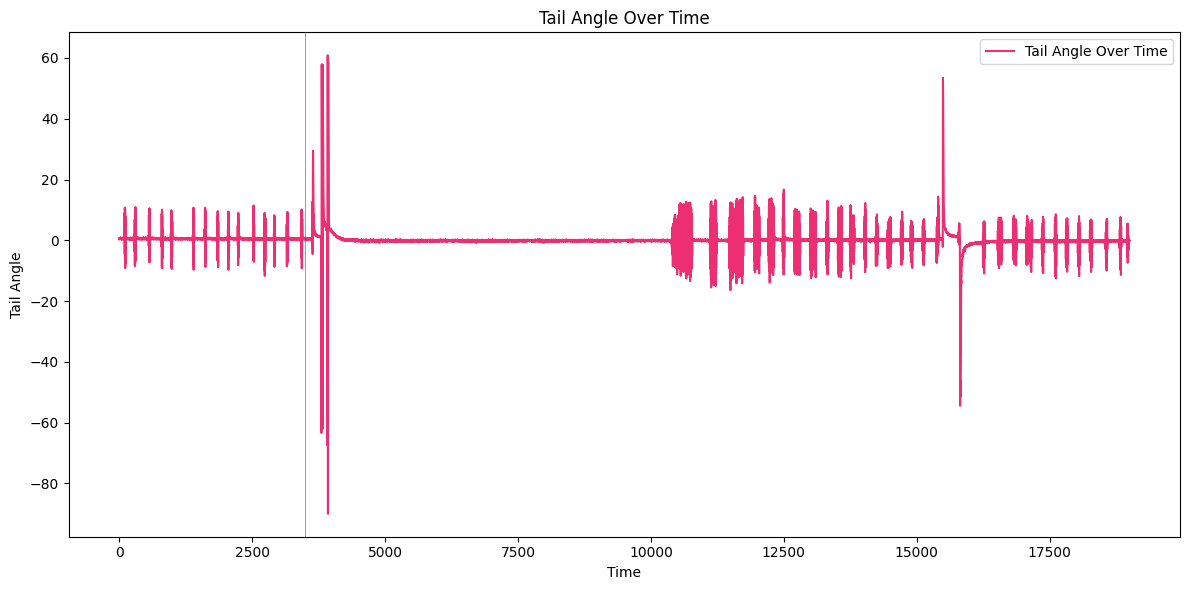

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
csv_path = r'C:\Maha\DATA\ventricle\F3_t3.csv'
df = pd.read_csv(csv_path)

# Assuming the CSV has columns 'time' and 'tailAngle'
x = df['time']
y = df['tailAngle']

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Tail Angle Over Time', color='#ee2e73')

# Add vertical lines from frame 960 to 1260
for frame in range(3500,3505):
    plt.axvline(x=frame, color='red', alpha=0.2, linewidth=0.5)

plt.xlabel('Time')
plt.ylabel('Tail Angle')
plt.title('Tail Angle Over Time')
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig(r'C:\Maha\DATA\ventricle\scontrol.svg')
plt.show()